GAT - Accuracy: 0.7180, F1: 0.7212, Time: 3.11s, Memory: 1594.85MB
GraphSAGE - Accuracy: 0.6910, F1: 0.7003, Time: 1.54s, Memory: 1596.43MB


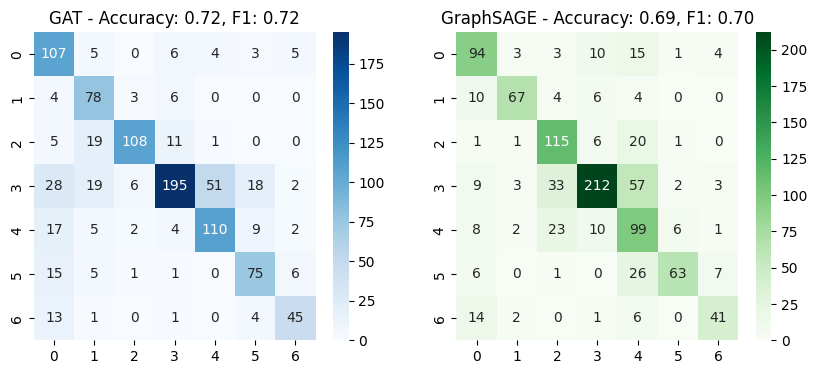

In [8]:
!pip install tensorflow numpy scipy scikit-learn memory_profiler matplotlib seaborn torch_geometric

import time
import numpy as np
import tensorflow as tf
import scipy.sparse as sp
import torch
from torch_geometric.datasets import Planetoid
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0]

edges = data.edge_index.numpy()
num_nodes = data.num_nodes
adj = sp.coo_matrix((np.ones(edges.shape[1]), (edges[0], edges[1])), shape=(num_nodes, num_nodes))
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
adj = adj + sp.eye(num_nodes)

adj = adj.tocoo()

A_tf = tf.SparseTensor(
    indices=np.array([adj.row, adj.col]).T.astype(np.int64),
    values=adj.data.astype(np.float32),
    dense_shape=adj.shape
)

X_tf = tf.convert_to_tensor(data.x.numpy(), dtype=tf.float32)
y_tf = tf.convert_to_tensor(data.y.numpy(), dtype=tf.int32)

train_mask = tf.convert_to_tensor(data.train_mask.numpy(), dtype=tf.bool)
test_mask = tf.convert_to_tensor(data.test_mask.numpy(), dtype=tf.bool)

class GNNLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation=None):
        super(GNNLayer, self).__init__()
        self.output_dim = output_dim
        self.activation = activation

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[0][-1], self.output_dim),
                                 initializer="glorot_uniform",
                                 trainable=True)

    def call(self, inputs):
        x, a = inputs
        x = tf.matmul(x, self.w)
        x = tf.sparse.sparse_dense_matmul(a, x)
        if self.activation:
            x = self.activation(x)
        return x

class GATModel(tf.keras.Model):
    def __init__(self, hidden_dim, num_classes):
        super(GATModel, self).__init__()
        self.gat1 = GNNLayer(hidden_dim, activation=tf.nn.relu)
        self.gat2 = GNNLayer(num_classes)

    def call(self, inputs):
        x, a = inputs
        x = self.gat1([x, a])
        x = self.gat2([x, a])
        return x

class GraphSAGEModel(tf.keras.Model):
    def __init__(self, hidden_dim, num_classes):
        super(GraphSAGEModel, self).__init__()
        self.sage1 = GNNLayer(hidden_dim, activation=tf.nn.relu)
        self.sage2 = GNNLayer(num_classes)

    def call(self, inputs):
        x, a = inputs
        x = self.sage1([x, a])
        x = self.sage2([x, a])
        return x

def train_model(model):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def train():
        for _ in range(50):
            with tf.GradientTape() as tape:
                out = model([X_tf, A_tf])
                loss = loss_fn(tf.boolean_mask(y_tf, train_mask), tf.boolean_mask(out, train_mask))
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

    start_time = time.time()
    mem_usage = memory_usage((train,), max_iterations=1)
    end_time = time.time()

    return end_time - start_time, max(mem_usage)

def evaluate_model(model):
    out = model([X_tf, A_tf])
    y_pred = tf.argmax(tf.boolean_mask(out, test_mask), axis=1)
    y_true = tf.boolean_mask(y_tf, test_mask)

    acc = accuracy_score(y_true.numpy(), y_pred.numpy())
    f1 = f1_score(y_true.numpy(), y_pred.numpy(), average='weighted')
    cm = confusion_matrix(y_true.numpy(), y_pred.numpy())

    return acc, f1, cm

gat_model = GATModel(hidden_dim=16, num_classes=dataset.num_classes)
gat_time, gat_memory = train_model(gat_model)
gat_acc, gat_f1, gat_cm = evaluate_model(gat_model)

sage_model = GraphSAGEModel(hidden_dim=16, num_classes=dataset.num_classes)
sage_time, sage_memory = train_model(sage_model)
sage_acc, sage_f1, sage_cm = evaluate_model(sage_model)

print(f"GAT - Accuracy: {gat_acc:.4f}, F1: {gat_f1:.4f}, Time: {gat_time:.2f}s, Memory: {gat_memory:.2f}MB")
print(f"GraphSAGE - Accuracy: {sage_acc:.4f}, F1: {sage_f1:.4f}, Time: {sage_time:.2f}s, Memory: {sage_memory:.2f}MB")

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(gat_cm, annot=True, cmap="Blues", fmt="d", ax=ax[0])
ax[0].set_title(f"GAT - Accuracy: {gat_acc:.2f}, F1: {gat_f1:.2f}")

sns.heatmap(sage_cm, annot=True, cmap="Greens", fmt="d", ax=ax[1])
ax[1].set_title(f"GraphSAGE - Accuracy: {sage_acc:.2f}, F1: {sage_f1:.2f}")

plt.show()
